## 6. Building Models with Risk Adjusted Metrics: Sortino Ratio
Once trades are modeled realistically, the next step is deciding how to measure whether trades are worth taking. Looking only at raw returns can be misleading; what matters is return relative to risk.

The Sharpe Ratio is one of the most widely used measures for evaluating the performance of an investment strategy relative to its risk. It calculates the excess return—meaning the return above the risk-free rate—per unit of total volatility. The formula divides the average excess return by the standard deviation of returns over a given period.

While the Sharpe Ratio can be useful for comparing different strategies on a normalized scale, it has some key weaknesses. The biggest issue is that it treats all volatility equally—both upside and downside. This means large positive returns increase the standard deviation just as much as large losses, which can unfairly penalize strategies that have positively skewed return distributions.

This is especially relevant for systematic trend-following strategies, which often produce a small number of very large positive outliers and same for the mean reversion strategies developed without take profit, just a trailing stop. In those cases, paradoxically, a higher Sharpe Ratio could be achieved by removing the largest winning trades—clearly not something an investor would want. It’s also worth noting that the Sharpe Ratio can be misleading when comparing strategies with different skew profiles, like comparing a trend-following system to an option-selling strategy. The first is often positively skewed, and the second negatively skewed. But the Sharpe doesn’t account for this difference, making it a poor basis for relative comparison.

In short, when return distributions aren’t symmetrical, the Sharpe Ratio doesn’t tell the full story. It can understate risk in negatively skewed strategies and overstate it in positively skewed ones.

To improve upon the shortcomings of the Sharpe Ratio, especially in strategies where returns are skewed, we rely on the Sortino Ratio. This metric refines the idea of risk-adjusted performance by only considering downside volatility—specifically, it looks at the standard deviation of returns that fall below a predefined threshold, usually zero or a target return.

The key point here is that upside volatility is not penalized. For long-only strategies—like the ones we build—this makes intuitive and practical sense. We care about losses and downside risk, not large positive deviations. A system that produces a few outsized gains shouldn't see its risk-adjusted score dragged down because of it, which is exactly what happens under the Sharpe framework.

The foundation for this measure traces back to Markowitz’s original insight, who recognized in the late 1950s that downside risk is more relevant than total variance. At the time, though, working with downside deviation was computationally unfeasible, so standard deviation became the default. In the 1980s, Frank Sortino and Brian Rom formalized and published the metric as a more appropriate way to assess the performance of return distributions that are not symmetrical.

In our framework, the Sortino Ratio is used systematically to validate and filter signals. If the average return adjusted for downside volatility is negative, the model avoids the trade. The goal isn’t to maximize the ratio itself but to use it as a consistent gatekeeper for quality control.

While our current systems focus on long exposure, the same logic can be inverted and applied to short-only strategies. In that case, the metric flips: it penalizes upside deviation instead, allowing the model to measure downside-targeted strategies symmetrically.

By grounding the model's decision-making in downside-aware statistics, we aim to build portfolios that take risk seriously—focusing on what actually matters in execution: protecting capital while staying exposed to asymmetric opportunity.

### 6.1. Dissecting the Ratio: Rolling Sortino Ratio

In our models, the Sortino Ratio is not calculated over the entire sample, but rather as a rolling metric, updated daily using the most recent 252 trading days (approximately one year). This allows us to continuously evaluate the evolving risk–return balance of each asset before accepting a signal. 

The rolling Sortino is computed as:

$$
\text{Sortino Ratio} = \frac{ \overline{R} - T }{ TDD }
$$

Where:
- $\overline{R}$ is the arithmetic mean of daily returns over the past 252 days 
- $T$ is the fixed **target return**, typically 0%  
- $TDD$ is the **Target Downside Deviation** over the same window  

The downside deviation is calculated as:

$$
TDD = \sqrt{ \frac{1}{N} \sum_{i=1}^{N} \left( \min(0, R_i - T) \right)^2 }
$$

Where:
- $R_i$ is the return on day $i$  
- $T$ is the target return  
- $N$ is the window size (e.g., 252)  

This mirrors the structure of the standard deviation formula:

$$
\sigma = \sqrt{ \frac{1}{N} \sum_{i=1}^{N} (R_i - \mu)^2 }
$$

But with key differences:

1. **It anchors returns against a fixed target $T$**, not the moving average $\mu$.
2. **It ignores returns above the target**, treating them as non-risk.

This adjustment is not cosmetic. In a long-only system, large upside deviations are beneficial, not risky. Penalizing them—as Sharpe does—distorts the perceived risk profile of the strategy. A trend-following or equity-biased system can show artificially low Sharpe values simply because of strong positive returns.

By contrast, the Sortino Ratio captures precisely what matters in our context: the ability to deliver returns while avoiding dips below a critical floor. This metric is embedded into our models as a gating condition—trades are only permitted when the rolling Sortino is above a threshold, typically 1.0.  

This ensures we are allocating risk to assets that not only trend, but trend with control.

### 6.2. Example: Sortino Ratio Calculation

To illustrate how our models evaluate downside risk, we calculate the 252-day rolling Sortino Ratio using real market data from the Micro E-mini Russell 2000 Futures (M2K). The rolling version is necessary because conditions change. A static Sortino computed on the full dataset won’t capture periods of poor risk-adjusted performance. We calculate a new ratio each day based on the last 252 trading days (1-year lookback).

**Step 1: Daily Returns**

For each day, compute the return as:

$$
R_i = \frac{P_i - P_{i-1}}{P_{i-1}}
$$

Where:
- $P_i$ is the closing price at day $i$

This gives us a time series of daily returns:  
$R_1, R_2, ..., R_N$

**Step 2: Excess Return vs Target**

Subtract the target return $T$ from each daily return:

$$
\text{Excess}_i = R_i - T
$$

We set $T = 0$ This means we’re only interested in whether the return was negative..


**Step 3: Downside Deviation**

To isolate negative outcomes, we take the minimum between each excess return and 0:

$$
D_i = \min(0, \text{Excess}_i)
$$

This way:
- If the return was above the target, it contributes 0 to the downside.
- If it was below, the shortfall is recorded.

**Step 4: Target Downside Deviation (Denominator)**

Now we compute the downside deviation, which is just the RMS (root mean square) of these shortfalls over a 252-day window:

$$
\text{TDD}_t = \sqrt{ \frac{1}{252} \sum_{j=t-251}^{t} D_j^2 }
$$

**Step 5: Mean Excess Return (Numerator)**

Compute the arithmetic mean of the excess returns over the same 252-day window:

$$
\bar{R}_t = \frac{1}{252} \sum_{j=t-251}^{t} \text{Excess}_j
$$

**Step 6: Sortino Ratio**

The Sortino Ratio on day $t$ is:

$$
\text{Sortino}_t = \frac{ \bar{R}_t }{ \text{TDD}_t }
$$

We multiply by $\sqrt{252}$ to annualize the value:

$$
\text{Sortino}_{\text{annualized}, t} = \text{Sortino}_t \times \sqrt{252}
$$

A Sortino Ratio above 1 indicates the strategy is delivering more return than downside risk. By definition, the average excess return exceeds the downside deviation. 

Figure 5 shows how the 252-day rolling Sortino Ratio evolves alongside the Micro E-mini Russell 2000 futures price. Notice that during strong upward trends (late 2024), the Sortino climbs well above 1, reflecting favorable risk-adjusted returns. Conversely, in the drawdown around March 2025, the ratio drops sharply below 0, highlighting periods where downside volatility dominated. The shaded regions emphasize this filter: green areas signal that returns per unit of downside risk were acceptable (Sortino > 1), while red areas indicate deteriorating conditions (Sortino ≤ 1). This dynamic view illustrates why we use a rolling window—risk-adjusted performance is not constant, and filtering out weak regimes is critical for robust strategy design.

[2025-11-16 17:46:29.737757] INFO: Norgate Data: NorgateData package v1.0.74: Init complete


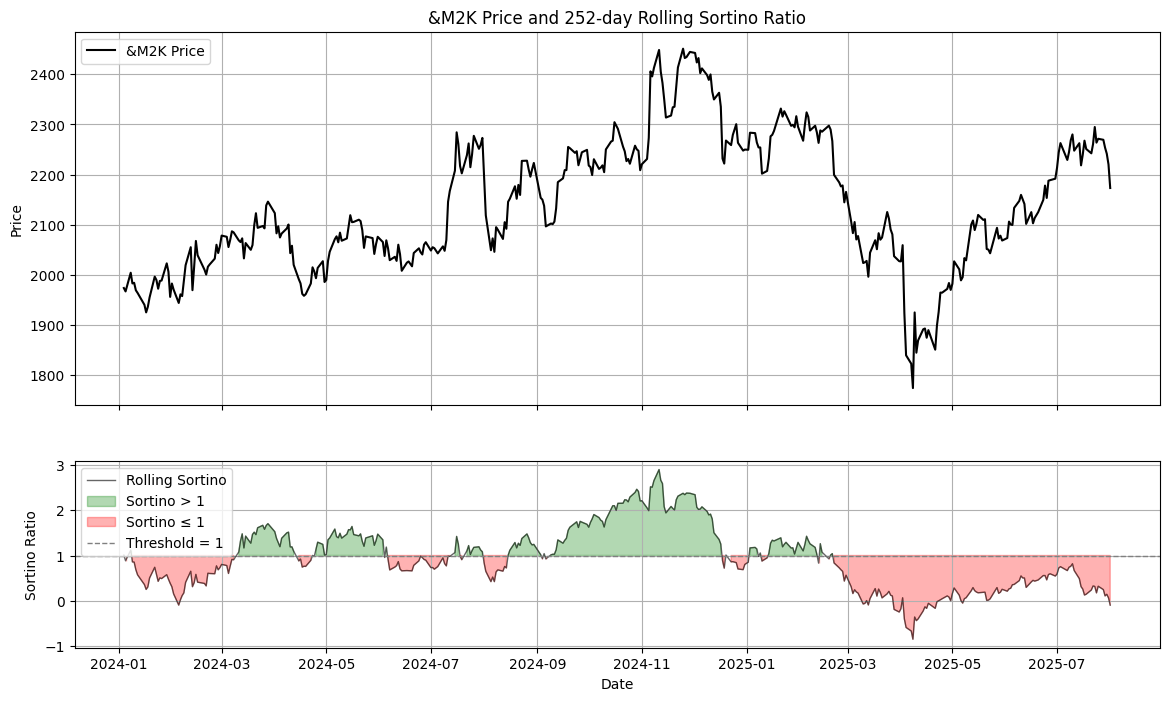

In [1]:
import norgatedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
symbol = '&M2K'
start_date = '2023-01-01'
end_date = '2025-08-01'
rolling_window = 252
target_return = 0.0
annualize_sortino = True

# Fetch data
df = norgatedata.price_timeseries(
    symbol,
    start_date=start_date,
    end_date=end_date,
    format='pandas-dataframe',
    stock_price_adjustment_setting=norgatedata.StockPriceAdjustmentType.NONE,
    padding_setting=norgatedata.PaddingType.NONE,
    timezone='UTC'
)

# Drop missing data
df = df.dropna(subset=['Close'])

# Compute daily returns
df['Returns'] = df['Close'].pct_change()

# Rolling Sortino Ratio
def rolling_sortino_ratio(returns, window, target=0.0, annualize=True):
    excess = returns - target
    downside = np.minimum(excess, 0.0)
    downside_dev = downside.rolling(window).apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
    avg_excess = excess.rolling(window).mean()
    sortino = avg_excess / downside_dev
    if annualize:
        sortino *= np.sqrt(252)
    return sortino

df['RollingSortino'] = rolling_sortino_ratio(df['Returns'], rolling_window, target=target_return, annualize=annualize_sortino)
df = df.iloc[rolling_window:].copy()  # warm-up period

# Create masked arrays for color-specific plots
sortino = df['RollingSortino']
above = np.ma.masked_where(sortino <= 1, sortino)
below = np.ma.masked_where(sortino > 1, sortino)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Price chart
ax1.plot(df.index, df['Close'], label=f'{symbol} Price', color='black')
ax1.set_ylabel('Price')
ax1.set_title(f'{symbol} Price and 252-day Rolling Sortino Ratio')
ax1.grid(True)
ax1.legend(loc='upper left')

# Sortino chart (no line gaps)
ax2.plot(df.index, df['RollingSortino'], color='black', linewidth=1, alpha=0.6, label='Rolling Sortino')

# Fill green where Sortino > 1
ax2.fill_between(df.index, df['RollingSortino'], 1, where=(df['RollingSortino'] > 1),
                 color='green', alpha=0.3, label='Sortino > 1')

# Fill red where Sortino ≤ 1
ax2.fill_between(df.index, df['RollingSortino'], 1, where=(df['RollingSortino'] <= 1),
                 color='red', alpha=0.3, label='Sortino ≤ 1')

# Add threshold line
ax2.axhline(1, color='gray', linestyle='--', linewidth=1, label='Threshold = 1')

# Labels and legend
ax2.set_ylabel('Sortino Ratio')
ax2.set_xlabel('Date')
ax2.grid(True)
ax2.legend(loc='upper left')



_Figure 5 - M2K Price and 252-day Rolling Sortino Ratio_

From a portfolio perspective, a Sortino above 1 is a basic quality filter. It means that the asset or strategy is producing return with a controlled level of risk on the downside. Anything below 1 suggests excess downside risk relative to return. Unless there’s a clear justification (such as hedging or convexity), it doesn’t merit capital.

In practice, we use the Sortino ratio to:

- Drop instruments where risk-adjusted performance deteriorates

- Keep exposure only where the trade-off between return and downside risk is favorable

- Maintain a systematic threshold (e.g. Sortino > 1) to filter noise from signal

The goal isn’t to chase the highest Sortino blindly, but to use it as a sanity check that aligns with how we think about real losses — not just volatility for its own sake.

We’ve defined the Sortino Ratio and shown how to compute it correctly. While it improves on Sharpe by focusing only on downside risk—closer to how investors actually experience losses—it has limitations. Like any backward-looking measure, it doesn’t predict future performance or capture structural shifts. It should be treated as one component within a broader risk framework, not a standalone decision tool, as will become clear in the next model constructions.